In [1]:
from data_science_tools.data_sources import BigQuery
import pandas as pd
import geopandas as gpd
import shapely.geometry

In [2]:
bq = BigQuery()

In [3]:
q = """
WITH
  cte AS (
  SELECT
    roof_geometry_id,
    json_extract_scalar(cape_roof_condition_rating , '$.Result.Prediction.Label') as rcr,
    json_extract_scalar(cape_roof_condition_rating , '$.Result.ImageDetails.Survey') as survey_id,
    CAST(FLOOR(tx/5000) AS INT), 
    CAST(FLOOR(ty/5000) AS INT),
    ROW_NUMBER() OVER (
      PARTITION BY 
        json_extract_scalar(cape_roof_condition_rating , '$.Result.Prediction.Label'),
        CAST(FLOOR(tx/7000) AS INT), 
        CAST(FLOOR(ty/7000) AS INT) 
      -- in the following we prioritize -2 but keep a random order within each group
      ORDER BY CASE WHEN json_extract_scalar(cape_roof_condition_rating , '$.Result.Prediction.Label') = '-2' THEN RAND() 
                    ELSE 2+RAND() END
      ) rn
  FROM
    `ml-dev-a7b7.cape_explorer.cape_attributes` 
  WHERE precomputejobid='6d85aeb6-f951-4c63-9ecd-cbe22cfab5f8'
    ),
  ids AS (
    SELECT
      *
    FROM
      cte as a
    WHERE
      rn <= 35000
  )
SELECT
  a.*,
  JSON_QUERY(c.gateway_response, '$.PrimaryStructure.Geometry') AS roof_geom,
FROM
  `ml-dev-a7b7.cape_explorer.cape_attributes` as c
JOIN ids as a
ON a.roof_geometry_id = c.roof_geometry_id
"""

res = bq.get_data(q)

In [4]:
df = res.to_dataframe()

<Axes: >

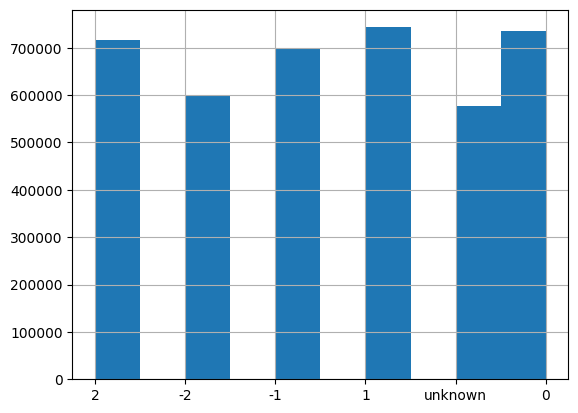

In [5]:
df['rcr'].hist()

In [6]:
df.shape

(3535616, 7)

In [6]:
# Let's get twice as many -2 and -1 then everything else
idx = df['rcr'].isin(['-2', '-1'])
n = idx.sum()
rest = df[~idx].sample(n // 2)
final_df = pd.concat([df[idx], rest]).reset_index(drop=True)
final_df.shape

(1947199, 7)

In [7]:
final_df.to_parquet("hey.parquet")

In [2]:
final_df = pd.read_parquet("hey.parquet")
final_df.head()

,roof_geometry_id,rcr,survey_id,f0_,f1_,rn,roof_geom
0,2951752844,-2,None,8,18,1629,"{""type"":""Polygon"",""coordinates"":[[[-122.278349..."
1,2822253489,-2,None,9,21,5585,"{""type"":""Polygon"",""coordinates"":[[[-116.907936..."
2,2898386557,-1,None,12,19,8965,"{""type"":""Polygon"",""coordinates"":[[[-96.7252173..."
3,2822753970,-1,None,14,19,19310,"{""type"":""Polygon"",""coordinates"":[[[-81.2615487..."
4,2944379472,-2,None,14,19,16954,"{""type"":""Polygon"",""coordinates"":[[[-82.9736591..."


In [15]:
final_df['geometry'] = final_df['roof_geom'].apply(lambda x: shapely.geometry.shape(eval(x)))
gdf = gpd.GeoDataFrame(final_df, crs='epsg:4326')
gdf['centroid'] = gdf['geometry'].centroid
gdf['lon'] = gdf['centroid'].x
gdf['lat'] = gdf['centroid'].y

/tmp/ipykernel_51361/3088343947.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


In [16]:
gdf.head(2)

,rcr,roof_geom,geometry,centroid,lon,lat
0,-2,"{""type"":""Polygon"",""coordinates"":[[[-116.907936...","POLYGON ((-116.90794 32.74339, -116.90794 32.7...",POINT (-116.90781 32.74335),-116.907815,32.743351
1,-2,"{""type"":""Polygon"",""coordinates"":[[[-118.010234...","POLYGON ((-118.01023 33.75896, -118.01029 33.7...",POINT (-118.01018 33.75854),-118.010182,33.758540


In [17]:
gdf[['rcr', 'lon', 'lat']].to_csv("raw_data_centroids.csv")

In [31]:
gdf[['rcr', 'geometry', 'lon', 'lat']].to_file("raw_data.gpkg", driver='GPKG')

In [44]:
gdf['rcr'].value_counts()

-1         787002
-2         678295
1          196194
0          194918
2          190006
unknown    151530
Name: rcr, dtype: int64

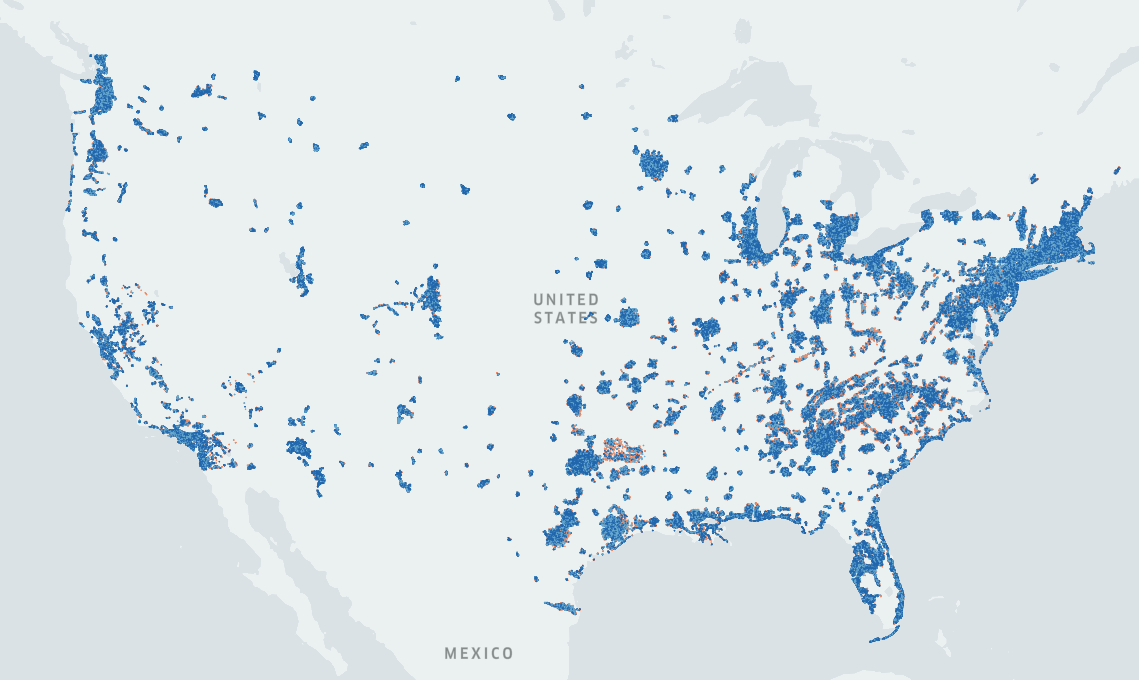

In [20]:
from data_store import DataStore
from data_store.data_containers import Experiments, Dataset
from data_store.storage import GCSStorage

import nest_asyncio
nest_asyncio.apply()

/opt/conda/lib/python3.8/site-packages/data_store/storage/gcs_utils/bulk_download.py:14: UserWarning: Running in jupyter notebook. Using threads instead of asyncio.If you need to download a large number of files consider running the download in a script.
  warnings.warn("Running in jupyter notebook. Using threads instead of asyncio."


In [21]:
gs = GCSStorage(
    # endpoint="http://0.0.0.0:4443", 
    path=f"gs://cape-ml-projects-data/data_stores"
)

In [22]:
ds = DataStore(name="dinov2", storage=gs)

Populating queue...
Download started...
queue fully populated. Found 1 files to download
Downloaded 1 files in 0.5 s


In [23]:
ds.list()

path,type,description
chips_raw_data,Dataset,Raw data for the creation of the chips stratifiedby RCR


In [24]:
# ds['chips_raw_data'] = Dataset(description="Raw data for the creation of the chips stratified by RCR")
ds['chips_raw_data'].upload("raw_data.gpkg")

Starting upload of 1 files
Completed 0/1 uploads in 1.0 s
Completed 0/1 uploads in 2.0 s
Completed 0/1 uploads in 3.0 s
Completed 0/1 uploads in 4.0 s
Completed 0/1 uploads in 5.0 s
Completed 0/1 uploads in 6.0 s
Completed 0/1 uploads in 7.0 s
Completed 0/1 uploads in 8.0 s
Completed 0/1 uploads in 9.0 s
Completed 0/1 uploads in 10.0 s
Completed 0/1 uploads in 11.0 s
Completed 0/1 uploads in 12.0 s
Completed 0/1 uploads in 13.0 s
Completed 0/1 uploads in 14.0 s
Completed 0/1 uploads in 15.0 s
Completed 0/1 uploads in 16.0 s
Completed 0/1 uploads in 17.0 s
Completed 0/1 uploads in 18.0 s
Completed 0/1 uploads in 19.0 s
Completed 0/1 uploads in 20.0 s
Completed 0/1 uploads in 21.0 s
Completed 0/1 uploads in 22.0 s
Completed 0/1 uploads in 23.0 s
Finished 1 uploads in 24.0 s


In [25]:
gdf.iloc[0]

rcr                                                         -2
roof_geom    {"type":"Polygon","coordinates":[[[-116.907936...
geometry     POLYGON ((-116.9079369306564 32.74339015941727...
centroid         POINT (-116.90781481710864 32.74335086111556)
lon                                                -116.907815
lat                                                  32.743351
Name: 0, dtype: object

In [26]:
gdf.shape

(2197945, 6)